# Tavily + LangGraph Agent 示例

In [7]:
! pip install -U langgraph langchain-openai


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


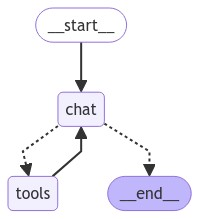

================================ Human Message =================================

帮我修改 payment 的工作负载，镜像为 nginx:v1.0
================================== Ai Message ==================================
Tool Calls:
  get_deployment (call_11aDySXGB85PljUEiWCuEo0O)
 Call ID: call_11aDySXGB85PljUEiWCuEo0O
  Args:
    deplyment_name: payment
get deployment:  payment
================================= Tool Message =================================
Name: get_deployment


apiVersion: apps/v1
kind: Deployment
metadata:
  name: payment
spec:
    selector:
        matchLabels:
        app: payment
    template:
        metadata:
        labels:
            app: payment
        spec:
        containers:
        - name: payment
            image: nginx
            ports:
            - containerPort: 80

================================== Ai Message ==================================
Tool Calls:
  apply_deployment (call_P5GgHGET6y9txFubRdiSCSMO)
 Call ID: call_P5GgHGET6y9txFubRdiSCSMO
  Args:
    patch_js

In [9]:
import os
from langchain_openai import ChatOpenAI
from typing import Literal
from langchain_core.tools import tool
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "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"
# LangSmith 项目名称，默认 default
os.environ["LANGCHAIN_PROJECT"] = "default"


@tool
def get_deployment(deplyment_name: str):
    """Use this to get deployment YAML."""
    print("get deployment: ", deplyment_name)
    return """
apiVersion: apps/v1
kind: Deployment
metadata:
  name: payment
spec:
    selector:
        matchLabels:
        app: payment
    template:
        metadata:
        labels:
            app: payment
        spec:
        containers:
        - name: payment
            image: nginx
            ports:
            - containerPort: 80
"""

@tool
def apply_deployment(patch_json: str):
    """Edit the deployment YAML."""
    print("apply deployment: ", patch_json)
    # 这里在后续的课程里会讲解调用 k8s API 来真正部署 patch_json
    return "deployment applied"

def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"

tools = [get_deployment, apply_deployment]
model_with_tools = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(tools)
tool_node = ToolNode(tools)
workflow = StateGraph(MessagesState)
workflow.add_node("chat", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "chat")
workflow.add_conditional_edges(
    "chat",
    should_continue,
)
workflow.add_edge("tools", "chat")
app = workflow.compile()

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

for chunk in app.stream(
    {"messages": [("human", "帮我修改 payment 的工作负载，镜像为 nginx:v1.0")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()